In [2]:
import matplotlib.pyplot as plt
import numpy as np
import json

from utils import Library

In [3]:
data_file = 'gutenberg/books.bin'
auxdata_file = 'gutenberg/books_metadata.json'

data = np.memmap(data_file, dtype=np.uint16, mode='r')
auxdata = []
with open(auxdata_file, 'r') as file:
    for line in file:
        auxdata.append(json.loads(line))

In [4]:
library = Library(data, auxdata)

In [7]:
num_blocks_per_book = []
for book in library:
    train_data = book['train_data']
    num_blocks_per_book.append(len(train_data))

In [18]:
batch_size = 8
num_batches_per_book = num_blocks_per_book // batch_size + 1

In [9]:
with open('results.json', 'r') as json_file:
    results = json.load(json_file)

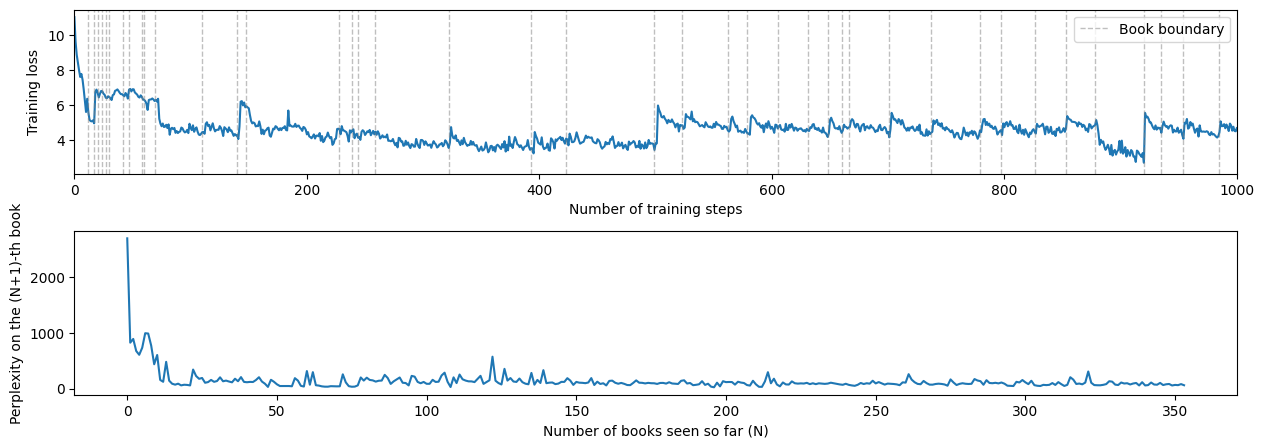

In [32]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(2, 1, figsize=(15, 5))
ax = axes[0]
ax.plot(results['tr_loss'])

for x in np.cumsum(num_batches_per_book):
    ax.axvline(x=x, color='gray', linestyle='--', linewidth=1, alpha=0.5)

ax.set_xlim([0, 1000])

ax.set_xlabel("Number of training steps")
ax.set_ylabel("Training loss")

custom_legend = [Line2D([0], [0], color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Book boundary')]
ax.legend(handles=custom_legend, loc='upper right')

ax = axes[1]
ax.plot(results['perplexity'])

ax.set_xlabel("Number of books seen so far (N)")
ax.set_ylabel("Perplexity on the (N+1)-th book")

plt.subplots_adjust(hspace=0.35)

plt.show()

In [2]:
with open('sc_results.json', 'r') as json_file:
    results = json.load(json_file)

with open('sc_pt_results.json', 'r') as json_file:
    pt_results = json.load(json_file)

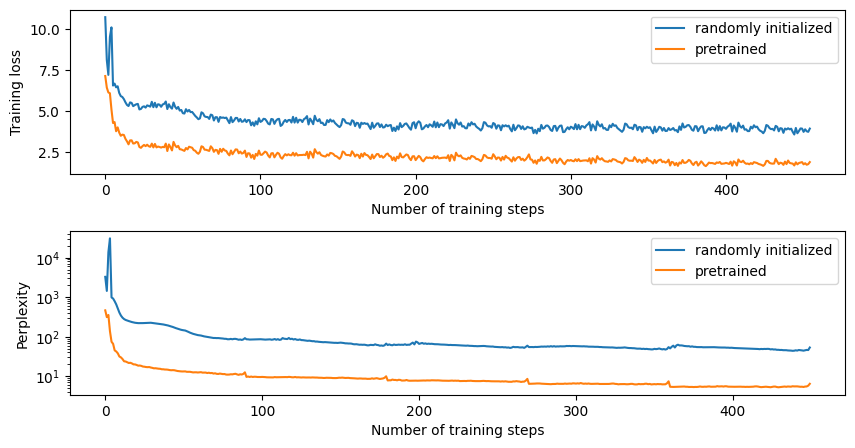

In [7]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(2, 1, figsize=(10, 5))

ax = axes[0]

ax.plot(results['tr_loss'], label='randomly initialized')
ax.plot(pt_results['tr_loss'], label='pretrained')

ax.set_xlabel("Number of training steps")
ax.set_ylabel("Training loss")

ax.legend()

ax = axes[1]

ax.plot(results['perplexity'], label='randomly initialized')
ax.plot(pt_results['perplexity'], label='pretrained')

ax.set_yscale('log')

ax.set_xlabel("Number of training steps")
ax.set_ylabel("Perplexity")

ax.legend()

plt.subplots_adjust(hspace=0.35)

plt.show()

In [3]:
def get_results(filename):
    results_file = f"results/{filename}.json"
    with open(results_file, 'r') as json_file:
        results = json.load(json_file)

    t, k = [], []
    truths, preds = [], []
    for result in results:
        if result['error'] is None:
            continue
        t.append(result['t'])
        k.append(result['k'])
        truths.append(result['truths'])
        preds.append(result['preds'])
    return np.array(t), np.array(k), truths, preds

def get_errors(t, truths, preds, T):
    perr = []
    for i in range(T-1):
        truths_t = np.concatenate([truths[idx] for idx in np.where(t == i)[0]])
        preds_t = np.concatenate([preds[idx] for idx in np.where(t == i)[0]])
        perr.append(np.mean(truths_t != preds_t))
    return perr

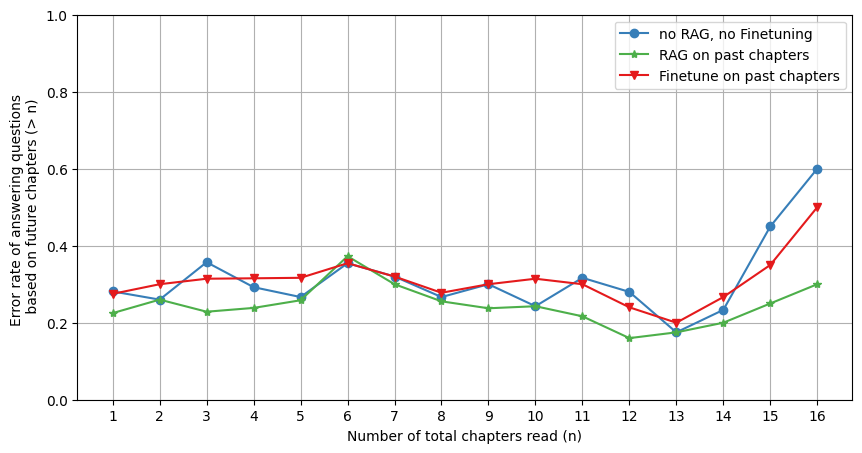

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# set the number of chapters
T = 17

t, k, truths, preds = get_results('vanilla')
perr = get_errors(t, truths, preds, T)
ax.plot(range(1, T), perr, color='#377eb8', label='no RAG, no Finetuning', marker='o')

t, k, truths, preds = get_results('rag')
perr = get_errors(t, truths, preds, T)
ax.plot(range(1, T), perr, color='#4daf4a', label='RAG on past chapters', marker='*')

t, k, truths, preds = get_results('ft')
perr = get_errors(t, truths, preds, T)
ax.plot(range(1, T), perr, color='#e41a1c', label='Finetune on past chapters', marker='v')

ax.set_xticks(range(1, T))
ax.set_ylabel("Error rate of answering questions \n based on future chapters (> n)")
ax.set_xlabel("Number of total chapters read (n)")
ax.set_ylim([0, 1])
ax.legend()
ax.grid()
plt.show()